In [1]:
print("\n\nம ஹா ம்ரி த் யு ஞ் ஜ யா\n\n")



ம ஹா ம்ரி த் யு ஞ் ஜ யா




In [2]:
import pandas as pd
import numpy as np
import time, os

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from keras.models import Model
from keras.layers import Input, LSTM, Dense, LSTMCell, RNN, Bidirectional, concatenate
from keras.optimizers import Adam

from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


Using TensorFlow backend.


In [3]:
path='/Users/manjunath.adinarayan/TIME-SERIES/YAHOO_Data/A1Benchmark/'
path='/Users/manjunath.adinarayan/TIME-SERIES/YAHOO_Data/A2Benchmark/'

file='real_38.csv'
file='synthetic_18.csv'
df = pd.read_csv(os.path.join(path,file), header=0)

In [4]:
df.head()

,timestamp,value,is_anomaly
0,1416726000,-109.796772,0
1,1416729600,105.443021,0
2,1416733200,-10.573313,0
3,1416736800,497.612830,0
4,1416740400,336.279685,0


In [5]:
series = df['value']

In [6]:
seq = series.copy()

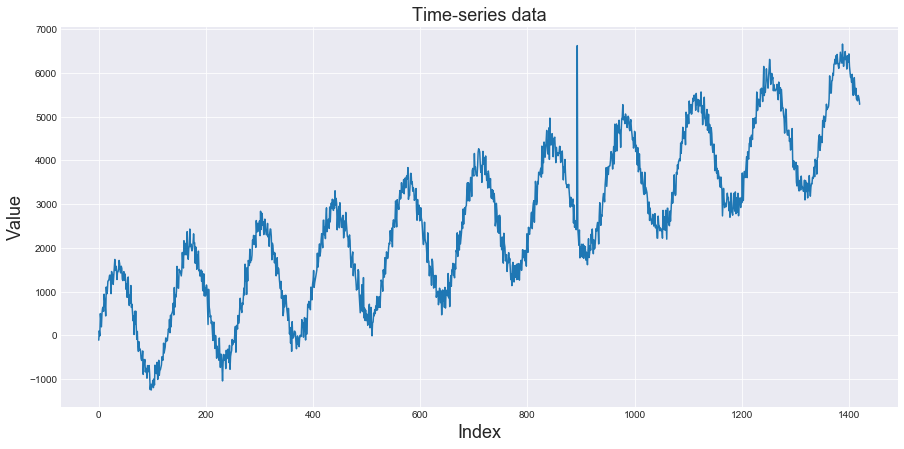

In [7]:
plt.figure(figsize=(15,7))
plt.title("Time-series data", fontsize = 18)
plt.xlabel("Index", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.plot(seq)
plt.show()

# START

functions

initializations

code flow

evaluation

plots

In [8]:
def get_score(y_true, y_pred):
    s = np.sqrt((y_true - y_pred)**2)
    
    return s

In [9]:
def data_preparing(data, filename, forecasting_length=1):
    test_signal = data.value.values
    #ma = moving_average(test_signal, n=24)
    #kpi = test_signal - ma # detrend
    kpi = test_signal
    kpi = np.array(kpi).reshape((len(kpi), 1))
    
    # train the standardization
    scaler = MinMaxScaler()
    scaler = scaler.fit(kpi)
    # standardization the dataset and print the first 5 rows
    normalized = scaler.transform(kpi)
    kept_value = normalized.flatten().tolist()

    kept_values = []
    for i in range(len(kept_value)):
        #kept_values.append([kept_value[i]]+time_encoder[i].tolist())
        kept_values.append(kept_value[i])
    X,Y, Y_anom_true_label = [],[], []
    for i in range(len(kept_values) - input_seq_len):
        t=i+input_seq_len
        X.append(kept_values[i:t])
        Y.append(kept_value[t:t + forecasting_length])
        if "Benchmark" in filename: 
            Y_anom_true_label.append(data.anomaly.values[t])
        else:
            Y_anom_true_label.append(data.is_anomaly.values[t])
        #Y_anom_true_label.append(data.is_anomaly.values[t])
    #X = np.asarray(X)
    X = np.expand_dims(X, axis=2)
    Y = np.expand_dims(Y, axis=2)
    
    Xmax = float(scaler.data_max_)
    Xmin = float(scaler.data_min_)

#    Xfull = X.transpose((1, 0, 2))
#    Yfull = Y.transpose((1, 0, 2))
 
    return X, Y, Xmax, Xmin, Y_anom_true_label

In [10]:
def generate_sequences(x):
    
    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), total_start_points, replace = False)
    
    input_batch_idxs = [(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(x, output_batch_idxs, axis = 0)
    
    input_seq =(input_seq.reshape(input_seq.shape[0],input_seq.shape[1],n_in_features))
    output_seq=(output_seq.reshape(output_seq.shape[0],output_seq.shape[1],n_out_features))
    
    return input_seq, output_seq

In [11]:
def create_model(layers, bidirectional=False):
    
    n_layers = len(layers)
    
    ## Encoder
    encoder_inputs = Input(shape=(None, n_in_features))
    lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
    if bidirectional:
        encoder = Bidirectional(RNN(lstm_cells, return_state=True))
        encoder_outputs_and_states = encoder(encoder_inputs)
        bi_encoder_states = encoder_outputs_and_states[1:]
        encoder_states = []
        for i in range(int(len(bi_encoder_states)/2)):
            temp = concatenate([bi_encoder_states[i],bi_encoder_states[2*n_layers + i]], axis=-1)
            encoder_states.append(temp)
    else:  
        encoder = RNN(lstm_cells, return_state=True)
        encoder_outputs_and_states = encoder(encoder_inputs)
        encoder_states = encoder_outputs_and_states[1:]
    
    ## Decoder
    decoder_inputs = Input(shape=(None, n_out_features))
    if bidirectional:
        decoder_cells = [LSTMCell(hidden_dim*2) for hidden_dim in layers]
    else:
        decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
        
    decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

    decoder_outputs_and_states = decoder_lstm(decoder_inputs,
                                          initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]

    decoder_dense = Dense(n_out_features) 
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
    return model

In [12]:
def run_model(model,batches,epochs,batch_size):
    early_stop_callback = EarlyStopping(monitor='val_loss', patience=16)
    checkpoint_callback = ModelCheckpoint(model_name, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

    for _ in range(batches):

        input_seq, output_seq = generate_sequences(x_train)

        encoder_input_data = input_seq
        decoder_target_data = output_seq
        decoder_input_data = np.zeros(decoder_target_data.shape)

        history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.2, 
                             verbose=0,
                             callbacks=[early_stop_callback, checkpoint_callback],
                             shuffle=False)
                           
        total_loss.append(history.history['loss'])
        total_val_loss.append(history.history['val_loss'])

In [13]:
input_seq_len = 48
output_seq_len = 1
n_in_features = 1
n_out_features = 1
batch_size = 64

model_name = 'best_saved_model.h5'

In [14]:

path='/Users/manjunath.adinarayan/TIME-SERIES/YAHOO_Data/A1Benchmark/'
path='/Users/manjunath.adinarayan/TIME-SERIES/YAHOO_Data/A2Benchmark/'

file='real_38.csv'
file='synthetic_48.csv'
df = pd.read_csv(os.path.join(path,file), header=0)

seq = df['value'].values

scaler = MinMaxScaler(feature_range=(-1,1))
X =scaler.fit_transform(seq.reshape(-1,1))

#train_split = 0.4
#test_split = 0.6
train_split = 0.8
test_split = 0.2

x_train = X[:int(len(X)*train_split)]
test = X[-int(len(X)*test_split):]

In [15]:
tr_input_seq, tr_output_seq = generate_sequences(x_train)
tst_input_seq, tst_output_seq = generate_sequences(test)

In [16]:
tr_input_seq.shape, tr_output_seq.shape, x_train.shape

((1087, 48, 1), (1087, 1, 1), (1136, 1))

In [17]:
tst_input_seq.shape, tst_output_seq.shape, test.shape

((235, 48, 1), (235, 1, 1), (284, 1))

In [18]:
Xfull, Yfull, Xmax, Xmin, Y_anom_true_label = data_preparing(df, file)
Xfull.shape, Yfull.shape, len(Y_anom_true_label)

((1373, 48, 1), (1373, 1, 1), 1373)

In [19]:
encoder_input_data = tr_input_seq
decoder_target_data = tr_output_seq
decoder_input_data = np.zeros(decoder_target_data.shape)

decoder_target_data.shape, decoder_input_data.shape

((1087, 1, 1), (1087, 1, 1))

# Unidirectional

In [20]:
model_1 = create_model(layers=[16,32,16],bidirectional=False)

total_loss = []
total_val_loss = []
model_1.compile(Adam(), loss = 'mean_squared_error')

start_time = time.time()
run_model(model_1,batches=1, epochs=100, batch_size=batch_size)
end_time = time.time()

run_time = (end_time - start_time)/60
run_time

1.371118966738383

In [21]:
model = load_model(model_name)

In [22]:
ts_enc_ip_data = tst_input_seq
ts_dec_ip_data = np.zeros(tst_output_seq.shape)

ts_pred_out = model.predict([ts_enc_ip_data, ts_dec_ip_data])
ts_pred_out.shape

(235, 1, 1)

In [23]:
full_enc_ip_data = Xfull
full_dec_ip_data = np.zeros(Yfull.shape)

full_pred_out = model.predict([full_enc_ip_data, full_dec_ip_data])
full_pred_out.shape

(1373, 1, 1)

In [24]:

f1score_dict2 = {}

prec_list2, rec_list2, f1score_list2 = [], [], []

In [25]:
####### ANOM-DETECT:
true_Yfull = Yfull.reshape(Yfull.shape[0], 1)
full_pred_out = full_pred_out.reshape(full_pred_out.shape[0], 1)

score = get_score(true_Yfull, full_pred_out)
pred_labels = []
for j in range(0, len(score)):
#    if score[j] <( np.mean(score) - 3.5*np.std(score) ) or score[j] >( np.mean(score) + 3.5*np.std(score) ):
    if score[j] <( np.mean(score) - 3*np.std(score) ) or score[j] >( np.mean(score) + 3*np.std(score) ):
#    if score[j] > np.percentile(score, 99):
        pred_labels.append(1)
    else:
        pred_labels.append(0)

prec_list2.append(precision_score(Y_anom_true_label, pred_labels) )
rec_list2.append(recall_score(Y_anom_true_label, pred_labels) )
f1score_list2.append(f1_score(Y_anom_true_label, pred_labels) )

f1score_dict2[file] = f1_score(Y_anom_true_label, pred_labels)
print( np.mean(prec_list2), np.mean(rec_list2), np.mean(f1score_list2) )


0.25 1.0 0.4


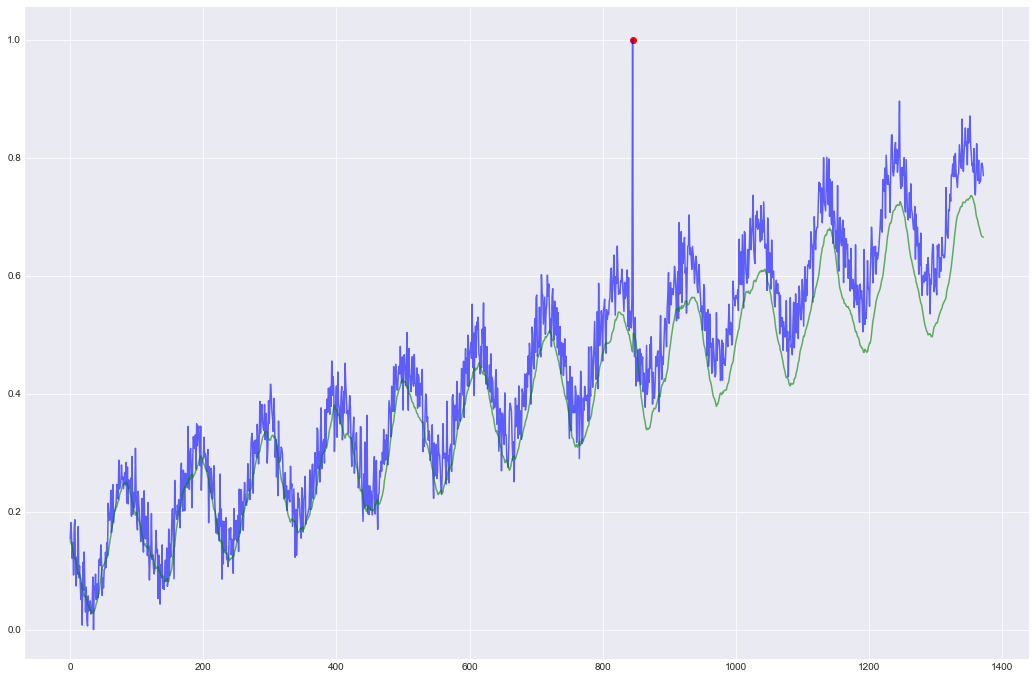

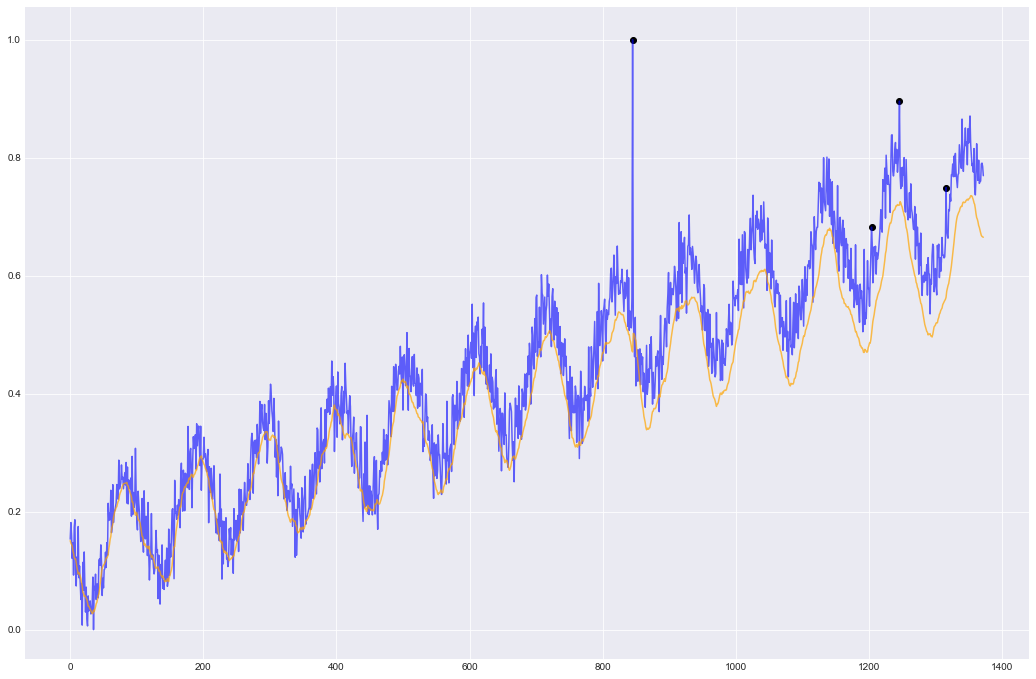

In [26]:
plt.rcParams['figure.figsize'] = [18, 12]

plt.figure()
plt.plot(true_Yfull, alpha = 0.6, color='blue')
plt.plot(full_pred_out, alpha = 0.6, color='green')
index_changes = np.where(np.asarray(Y_anom_true_label) == 1)[0]
plt.scatter(index_changes, true_Yfull[index_changes], c = 'red', label = "change point")
plt.show()


plt.figure()
plt.plot(true_Yfull, alpha = 0.6, color='blue')
plt.plot(full_pred_out, alpha = 0.7, color='orange')
tr_index_changes = np.where(np.asarray(pred_labels) == 1)[0]
plt.scatter(tr_index_changes, true_Yfull[tr_index_changes], c='black', label="change point")
plt.show()

In [27]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

In [28]:
def plot_loss(train_loss,val_loss):
    plt.figure(figsize=(12,7))
    plt.plot(train_loss)
    plt.plot(val_loss)

    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqquared Error Loss')
    plt.title('Loss Over Time')
    plt.legend(['Train','Valid'])
    plt.show()

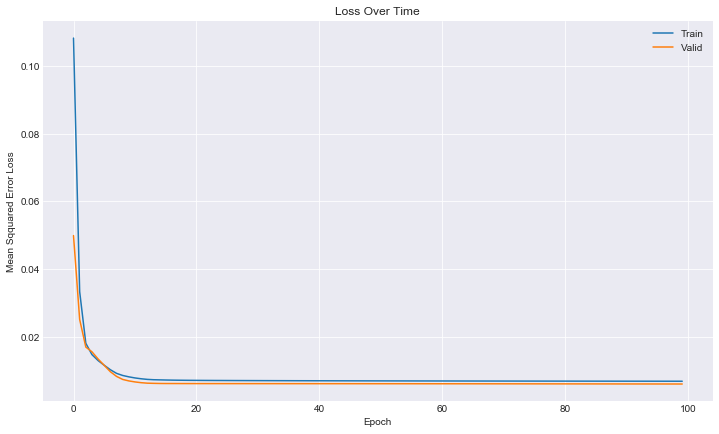

In [29]:
plot_loss(total_loss,total_val_loss)